In [1]:
import os
import sys
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# import seaborn as sns
from scipy import integrate, signal, stats, fftpack
from glob import glob
import mne

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Functions

### Subjects

In [5]:
## Mice that have at least one recovery state ##
sub_dirs = {
#     '521885': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\estim1_2020-07-09_14-23-49\recording1',
#     '521886': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521886\estim1_2020-07-16_13-37-02\recording1',
#     '521887': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521887\estimfull_2020-07-30\experiment1\recordingfull',
#     '543393': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543393\estim1_2020-08-20_13-24-53\experiment1\recording1',
#     '543394': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543394\estim1_2020-08-27_14-32-00\experiment1\recording1',
#     '543395': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543395\estim1_2020-09-03_13-19-42\experiment1\recording1',
#     '543396': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1',
#     '546655': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
    '551400': r'F:\EEG_exp\mouse551400\estim_vis_2021-01-22_11-07-12\experiment1\recording1',
#     '551399': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551399\estim_2021-01-28_13-59-09\experiment1\recording1',
#     '551397': r'F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1',
#     '569062': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse569062\estim_vis_2021-02-18_11-17-51\experiment1\recording1',
#     '569068': r'F:\EEG_exp\mouse569068\estim_vis_2021-03-04_10-51-38\experiment1\recording1',
    '569069': r'F:\EEG_exp\mouse569069\estim_vis2_2021-03-12_10-52-44\experiment1\recording1',
}

## Sweep ids for each brain state
brain_states = {
    '521885': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [], 'recovery_30-60min': []},
    '521886': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': []},
    '521887': {'awake': [0, 1], 'anesthetized': [2, 3, 4], 'recovery_0-30min': [5, 6, 7], 'recovery_30-60min': []},
    '543393': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5], 'recovery_0-30min': [6, 7, 8], 'recovery_30-60min': []},
    '543394': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5], 'recovery_0-30min': [6, 7, 8], 'recovery_30-60min': []},
    '543395': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5, 6], 'recovery_0-30min': [7, 8, 9], 'recovery_30-60min': []},
    '543396': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': []},
    '546655': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': []}, # sweep 3 was incomplete
    '551400': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '551399': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '551397': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '569062': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': []},
    '569068': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '569069': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
}

In [6]:
## Stim amplitudes for the PCI calculation
PCI_stim_amp = {
    '521885': 50,
    '521886': 50,
    '521887': 20,
    '543393': 70,
    '543394': 50,
    '543395': 60,
    '543396': 80,
    '546655': 70,
    '551400': 50,
    '551399': 60,
    '551397': 30,
    '569062': 35,
    '569068': 20,
    '569069': 40,
}

### Load experiments

In [7]:
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation


### Load eeg data and gather stim-evoked traces, avg traces, and filtered traces?

In [8]:
## parameters ##
before_event = 1. # s, look at 1 s pre-stim
after_event = 1. # s, look at 1 s post-stim

apply_mask = True
apply_car = True

In [9]:
start = time.time()

estim_traces = {}
sub_good_chs = {}
for mousei, expi in sub_exp.items():
    print(mousei)
    
    # load stim log
    stim_log, good_chs = expi.qualitycheck_trials_chs()
    amps_list = np.sort(stim_log.loc[stim_log.stim_type == 'biphasic', 'parameter'].unique())
    
    # load data
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(0, datai.shape[1])
    
    # mask estim artifact
    if apply_mask:
        mask_samples = int(0.002 * expi.ephys_params['EEG']['sample_rate'])
        for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
            val = find_nearest_ind(tsi, etime) - 2
            datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]
    
    # get evoked traces
    estim_traces[mousei] = {}
    sub_good_chs[mousei] = {}
    
    for statei, sweeps in brain_states[mousei].items():
        if sweeps:
            estim_traces[mousei][statei] = {}
            sub_good_chs[mousei][statei] = {}
            
            for ampi in amps_list:
                
                traces = []
                goodchlist = []
                for sweepi in sweeps:
                    events = get_stim_events(stim_log, 'biphasic', ampi, sweepi)
                    if len(events) == 0:
#                         print('{}, {}, sweep {:d}: no good trials found'.format(st_type, str(ampi), sweepi))
                        continue
#                     print('{}, {}, sweep {:d}: {:d} good trials'.format(st_type, str(ampi), sweepi, len(events)))
                    goodchlist.append(good_chs['biphasic'][ampi][sweepi])
                    event_traces, event_ts = get_evoked_traces(
                        datai,
                        tsi,
                        events,
                        before_event,
                        after_event,
                        expi.ephys_params['EEG']['sample_rate']
                    )
                    traces.append(event_traces)
            
                state_traces = np.concatenate(traces, axis=2)
                state_good_chs = np.array(list(set.intersection(*map(set, goodchlist))))
                
                # apply common avg
                if apply_car:
                    state_traces = state_traces - np.mean(state_traces[:, state_good_chs, :], axis=1)[:,None,:]
                    
                # apply lowpass filter
                filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')
                
                estim_traces[mousei][statei][str(ampi)] = [event_ts, signal.filtfilt(filtb, filta, state_traces, axis=0)]
                sub_good_chs[mousei][statei][str(ampi)] = state_good_chs
            
    del datai
    del tsi
    del stim_log

end = time.time()
print('Time to analyze: {:.2f} min'.format((end - start) / 60))

551400
569069
Time to analyze: 1.68 min


## Examining spatial distribution of components

<IPython.core.display.Javascript object>


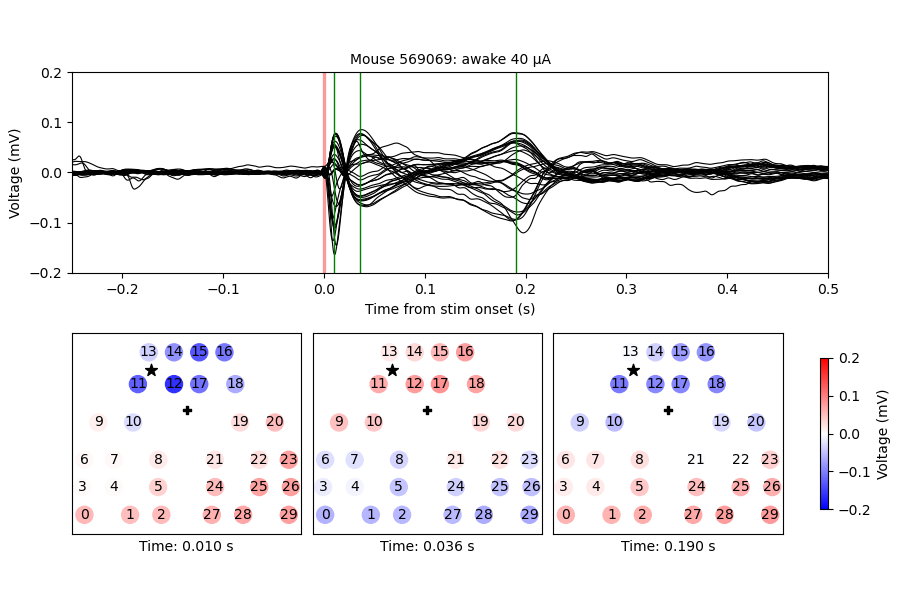

In [23]:
hm_times = [0.01, 0.036, 0.19] # [0.006, 0.025, 0.1, 0.16, 0.2] [0.01, 0.03, 0.1, 0.17, 0.22]
plot_window = [-0.25, 0.5]

subject = '569069'
state = 'awake'
stimamp = '40'

vlim = 0.2

plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse'+subject)

timex = estim_traces[subject][state][stimamp][0]
traces = np.mean(estim_traces[subject][state][stimamp][1], axis=2)/1000
GOOD_CHS = sub_good_chs[subject][state][stimamp]
pinds = np.nonzero((timex >= plot_window[0]) & (timex <= plot_window[1]))[0]

fig = plt.figure(figsize=(9,6)) #, constrained_layout=True)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.08, right=0.92, hspace=0.3)

## Top: butterfly plot ##
bfax = fig.add_subplot(gs[0])
bfax.plot(timex[pinds], traces[pinds,:][:,GOOD_CHS], 'k', linewidth=0.8)
bfax.axvspan(-0.001, 0.001, color='r', alpha=0.3)
for timei in hm_times:
    bfax.axvline(timei, color='g', linewidth=1)
bfax.set_xlim(plot_window)
bfax.set_xlabel('Time from stim onset (s)')
bfax.set_ylim([-vlim, vlim])
bfax.set_ylabel('Voltage (mV)')
bfax.set_title('Mouse {}: {} {} \u03BCA'.format(subject, state, stimamp))

## Bottom: plot scatter plot heat maps for each time point ##
gsi = gs[1].subgridspec(ncols=len(hm_times), nrows=1, wspace=0.05)
axlist = []
for coli, timei in enumerate(hm_times):
    hmax = fig.add_subplot(gsi[coli])
    timeinds = np.nonzero((timex >= timei - 0.0005) & (timex <= timei + 0.0005))[0]
    ch_values = np.mean(traces[timeinds, :], axis=0)
    
    hmsc = hmax.scatter(
        EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS],
        EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS],
        c=ch_values[GOOD_CHS],
        s=150,
        cmap='bwr',
        vmin=-vlim,
        vmax=vlim,
    )
    hmax.scatter(0, 0, marker='P', color='k')
    hmax.scatter(-1.4, 1.6, marker='*', color='k', s=80)
    hmax.axis('equal')
    hmax.set_xticks([])
    hmax.set_yticks([])
    hmax.set_xlabel('Time: {:.3f} s'.format(timei))

#     for ind in range(len(EEGexp.EEG_channel_coordinates)):
    for ind in GOOD_CHS:
        hmax.annotate(str(ind),  xy=(EEGexp.EEG_channel_coordinates['ML'].iloc[ind], EEGexp.EEG_channel_coordinates['AP'].iloc[ind]), ha='center', va='center', color="k")
    axlist.append(hmax)
cb = fig.colorbar(hmsc, ax=axlist, fraction=0.01)
cb.set_label('Voltage (mV)')

## Save ##
figname = 'bf_heatmap_{}{}.png'.format(state, stimamp)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

### Calculate PCIst, match trial numbers of states

In [11]:
states = ['awake', 'anesthetized']

PCI_params = {
    'baseline_window': (-0.8, -0.005), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.005, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

full_PCI_output = {}
justPCI = {}
avg_traces = {}
for subject in estim_traces.keys():
    print(subject)
    start = time.time()
    
    PCIamp = str(PCI_stim_amp[subject])
    GOOD_CHS = np.array(list(set.intersection(*map(set, [sub_good_chs[subject][x][PCIamp] for x in states]))))
    NUM_TRIALS = min([estim_traces[subject][x][PCIamp][1].shape[2] for x in states])
    print('Good channels: {:d}'.format(GOOD_CHS.shape[0]))
    print('Trials: {:d}'.format(NUM_TRIALS))
    
    full_PCI_output[subject] = {}
    justPCI[subject] = {}
    avg_traces[subject] = {}
    for statei in states:
        ## Subselect trials and take avg ##
        if statei == 'recovery':
            state_traces = np.mean(estim_traces[subject][statei][PCIamp][1][:, :, -NUM_TRIALS:], axis=2)
        else:
            state_traces = np.mean(estim_traces[subject][statei][PCIamp][1][:, :, :NUM_TRIALS], axis=2)
#         avg_traces[subject][statei] = [estim_traces[subject][statei][PCIamp][0], state_traces]
        
        ## Calculate PCIst with full return ##
#         full_PCI_output[subject][statei] = calc_PCIst(
#             state_traces[:, GOOD_CHS].T,
#             estim_traces[subject][statei][PCIamp][0],
#             full_return=True,
#             **PCI_params
#         )
        justPCI[subject][statei] = calc_PCIst(
            state_traces[:, GOOD_CHS].T,
            estim_traces[subject][statei][PCIamp][0],
            full_return=False,
            **PCI_params
        )

#         print('{:s} PCI = {:.3f}'.format(statei, full_PCI_output[subject][statei]['PCI']))
        print('{:s} PCI = {:.3f}'.format(statei, justPCI[subject][statei]))
    end = time.time()
    print('Time: {:.2f} s'.format(end-start))
    print('')

521885
Good channels: 25
Trials: 59
awake PCI = 74.573
anesthetized PCI = 24.339
Time: 569.53 s

521886
Good channels: 23
Trials: 99
awake PCI = 36.621
anesthetized PCI = 6.357
Time: 278.25 s

521887
Good channels: 24
Trials: 200
awake PCI = 65.923
anesthetized PCI = 7.693
Time: 424.00 s

543393
Good channels: 26
Trials: 300
awake PCI = 50.906
anesthetized PCI = 12.504
Time: 351.84 s

543394
Good channels: 21
Trials: 299
awake PCI = 25.773
anesthetized PCI = 11.707
Time: 335.33 s

543395
Good channels: 24
Trials: 165
awake PCI = 65.604
anesthetized PCI = 123.213
Time: 659.60 s

543396
Good channels: 20
Trials: 71
awake PCI = 38.949
anesthetized PCI = 9.449
Time: 344.07 s

546655
Good channels: 30
Trials: 105
awake PCI = 51.268
anesthetized PCI = 13.892
Time: 342.72 s

551400
Good channels: 30
Trials: 117
awake PCI = 71.493
anesthetized PCI = 29.332
Time: 489.42 s

551399
Good channels: 28
Trials: 120
awake PCI = 40.901
anesthetized PCI = 27.704
Time: 412.29 s

551397
Good channels: 28


#### Plot PCI values

In [13]:
sub_list = ['521885', '521886', '521887', '543393', '543394', '543396', '546655', '551399', '551397']
# justPCI = {}
# # for mousei in full_PCI_output.keys():
# for mousei in sub_list:
#     justPCI[mousei] = {}
#     for statei in full_PCI_output[mousei].keys():
#         justPCI[mousei][statei] = full_PCI_output[mousei][statei]['PCI']
        
PCI = {}
for mousei in sub_list:
    PCI[mousei] = {}
    for statei in justPCI[mousei].keys():
        PCI[mousei][statei] = justPCI[mousei][statei]

In [14]:
# pci_eqn = pd.DataFrame(justPCI)
pci_eqn = pd.DataFrame(PCI)
PCIvalues_eqn = pci_eqn.to_numpy()
pci_eqn.head()

,521885,521886,521887,543393,543394,543396,546655,551399,551397
awake,74.573178,36.620546,65.923298,50.906330,25.773025,38.94890,51.267636,40.90057,78.702773
anesthetized,24.339189,6.356819,7.693001,12.503859,11.707126,9.44899,13.892071,27.70413,22.656895


#### Paired t-test
<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel

In [15]:
## Calculate the t-test on TWO RELATED samples of scores, a and b.
t2, p2 = stats.ttest_rel(PCIvalues_eqn[0,:], PCIvalues_eqn[1,:])
print("t = " + str(t2))
print("p = " + str(p2))
### is this a paired ttest???

t = 6.6073484355447905
p = 0.00016809458648844966


Wilcoxon signed rank sum test (for non-normal distributions)
<br>The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

<IPython.core.display.Javascript object>


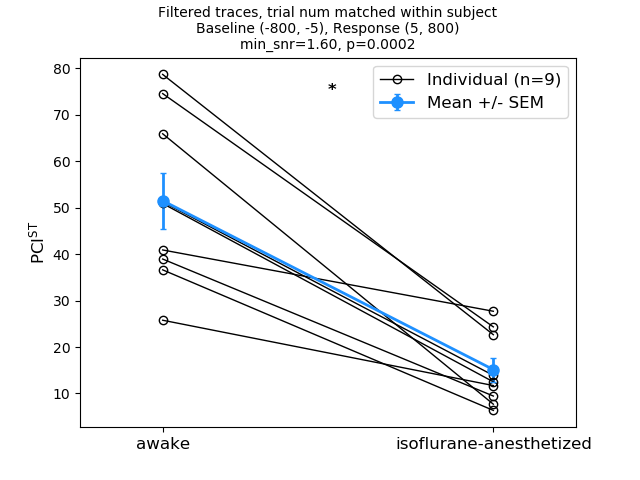

In [17]:
fig, ax = plt.subplots()
# plot individuals with unfilled circles
individs = ax.plot(
    np.arange(0, PCIvalues_eqn.shape[0]),
    PCIvalues_eqn,
    color='k',
    linewidth=1,
    marker='o',
    fillstyle='none'
)
# plot mean +/- SEM with filled circles
mean_sem = ax.errorbar(
    np.arange(0, PCIvalues_eqn.shape[0]),
    np.mean(PCIvalues_eqn, axis=1),
    yerr=stats.sem(PCIvalues_eqn, axis=1),
    color='dodgerblue',
    linewidth=2,
    marker='o',
    markersize=8,
)
# annotate with asterisk
ax.annotate('*', xy=(0.5,0.9), xycoords='axes fraction', fontsize=12, fontweight='bold')

ax.set_xlim([-0.25, 1.25])
ax.set_xticks(np.arange(0, PCIvalues_eqn.shape[0]))
ax.set_xticklabels(['awake', 'isoflurane-anesthetized'], fontsize=12)
ax.set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=12)
ax.legend([individs[0], mean_sem], [('Individual (n={:d})'.format(PCIvalues_eqn.shape[1])), 'Mean +/- SEM'], fontsize=12)
ax.set_title(
    'Filtered traces, trial num matched within subject\nBaseline ({:d}, {:d}), Response ({:d}, {:d})\nmin_snr={:.2f}, p={:.4f}'.format(
        int(PCI_params['baseline_window'][0]*1000),
        int(PCI_params['baseline_window'][1]*1000),
        int(PCI_params['response_window'][0]*1000),
        int(PCI_params['response_window'][1]*1000),
        PCI_params['min_snr'],
        p2
    ))

## Save
# fig.savefig(os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'PCIst_9goodmice_800ms_Feb1621.png'), transparent=True)

## Plotting traces

#### Make butterfly plots for all mice in one figure

<IPython.core.display.Javascript object>


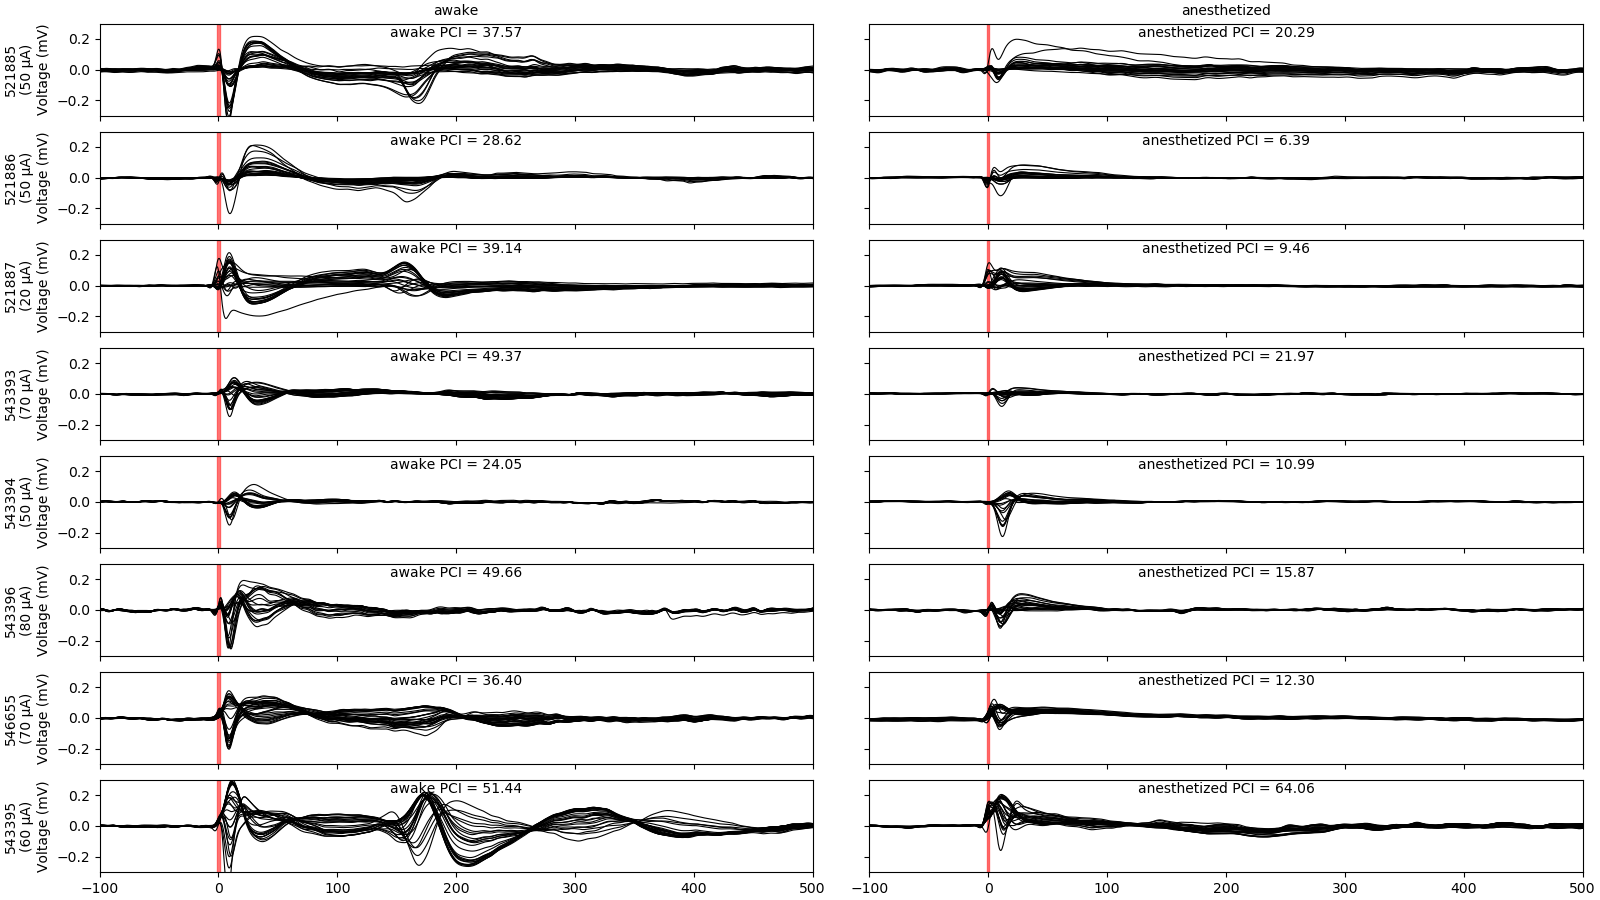

In [78]:
sub_list = ['521885', '521886', '521887', '543393', '543394', '543396', '546655', '543395']

prex = 100 # ms before stim to plot
postx = 500 # ms after stim to plot
bf_ylimit = 0.3 # mV

plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'

# fig, axs = plt.subplots(len(bf_avg_traces.keys()), len(states), figsize=(16, 9), sharex=True, sharey=True)#, constrained_layout=True)
# for row, subject in enumerate(bf_avg_traces.keys()):
fig, axs = plt.subplots(len(sub_list), len(states), figsize=(16, 9), sharex=True, sharey=True, constrained_layout=True)
for row, subject in enumerate(sub_list):
    good_chs = [x for x in eegchs if x not in bad_chs[subject]]

    ## Butterfly figure not including bad chs ##
    for col, statei in enumerate(bf_avg_traces[subject].keys()):
        pick_traces = bf_avg_traces[subject][statei][1]/1000 # or sub_avg_traces_filter
        pick_times = bf_avg_traces[subject][statei][0]
        plot_inds = np.squeeze(np.argwhere((pick_times >= -prex) & (pick_times <= postx)))
        
        axs[row,col].plot(pick_times[plot_inds], pick_traces[plot_inds,:][:, good_chs], color='k', linewidth=0.8)
        axs[row,col].axvspan(-1, 1, color='r', alpha=0.5)

        axs[row,col].text(
            0.5, 0.9,
            ('{:s} PCI = {:.2f}'.format(statei, full_PCI_output[subject][statei]['PCI'])),
            horizontalalignment='center',
            verticalalignment='center',
            transform = axs[row,col].transAxes
        )
        if row == 0:
            axs[0,col].set_title(('{:s}'.format(statei)), fontsize=10)
    axs[row,0].set_ylabel('{:s}\n({:d} \u03BCA)\nVoltage (mV)'.format(subject, PCI_stim_amp[subject]))

axs[0,0].set_xlim([-prex, postx])
axs[0,0].set_ylim([-bf_ylimit, bf_ylimit])
# axs[-1,:].set_xlabel('Time from stim onset (ms)')


## Save butterfly figure ##
# fig.savefig(os.path.join(plotdir, 'allmice_evokedEEG_wPCI.png'), transparent=True)

#### Plot all mice, awake or anesthetized butterfly plots

<IPython.core.display.Javascript object>


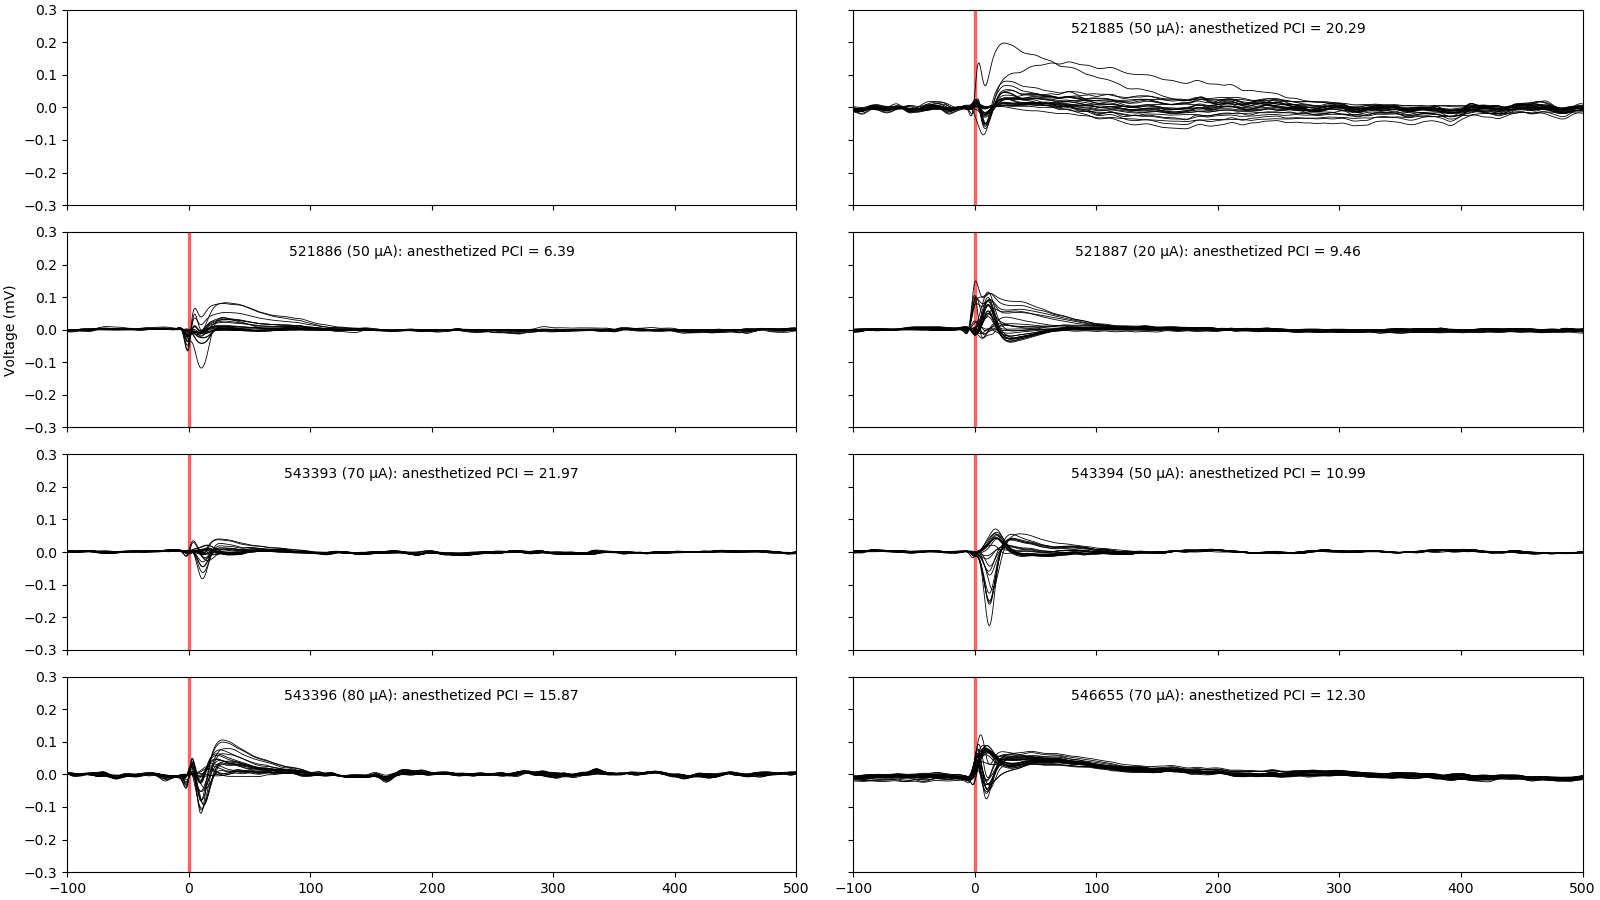

In [18]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots')
statei = 'anesthetized' # 'awake' or 'anesthetized'

prex = 100 # ms before stim to plot
postx = 500 # ms after stim to plot
bf_ylimit = 0.3 # mV
color_hemisphere = False

fig, axs = plt.subplots(4, 2, figsize=(16, 9), sharex=True, sharey=True, constrained_layout=True)
for ax, subject in zip(axs.flatten()[1:], bf_avg_traces.keys()):
    good_chs = [x for x in eegchs if x not in bad_chs[subject]]
    
    pick_traces = bf_avg_traces[subject][statei][1]/1000 # or sub_avg_traces_filter
    pick_times = bf_avg_traces[subject][statei][0]
    plot_inds = np.squeeze(np.argwhere((pick_times >= -prex) & (pick_times <= postx)))
    if color_hemisphere:
        for chi in good_chs:
            if chi < 15:
                ax.plot(pick_times[plot_inds], pick_traces[plot_inds, chi], color=trace_colors['left'], linewidth=0.7)
            else:
                ax.plot(pick_times[plot_inds], pick_traces[plot_inds, chi], color=trace_colors['right'], linewidth=0.7)
    else:
        ax.plot(pick_times[plot_inds], pick_traces[plot_inds,:][:, good_chs], color='k', linewidth=0.6)
    ax.axvspan(-1, 1, color='r', alpha=0.5)
    ax.set_ylim([-bf_ylimit, bf_ylimit])

    ax.set_xlim([-prex, postx])
#     ax.set_xlabel('Time from stim onset (ms)')

#     ax.set_title(('%s PCI = %0.2f' % (statei, full_PCI_output[subject][statei]['PCI'])), fontsize=10)
    ax.text(
        0.5, 0.9,
        ('{:s} ({:d} \u03BCA): {:s} PCI = {:.2f}'.format(subject, PCI_stim_amp[subject], statei, full_PCI_output[subject][statei]['PCI'])),
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
    )

axs[1,0].set_ylabel('Voltage (mV)')
## Save butterfly figure ##
# fig.savefig(os.path.join(plotsavedir, 'mice7_BF_100HzButterworthfilter_ISO.png'), transparent=True)

#### Plot all mice, awake or anesthetized butterfly plots, COLORED BY DISTANCE

In [20]:
stim_elec_AP = 1.4 # mm, with respect to bregma (pos is anterior)
stim_elec_ML = -1.2 # mm, with respect to bregma (neg is left hemi)

## ML in x position, AP in y ##
ch_coords = np.column_stack((EEGexp.EEG_channel_coordinates['ML'], EEGexp.EEG_channel_coordinates['AP']))
stim_elec_coords = np.array([stim_elec_ML, stim_elec_AP])

## Calculate the Euclidean distance to each electrode ##
ch_distances = np.linalg.norm(ch_coords - stim_elec_coords, axis=1)

<IPython.core.display.Javascript object>


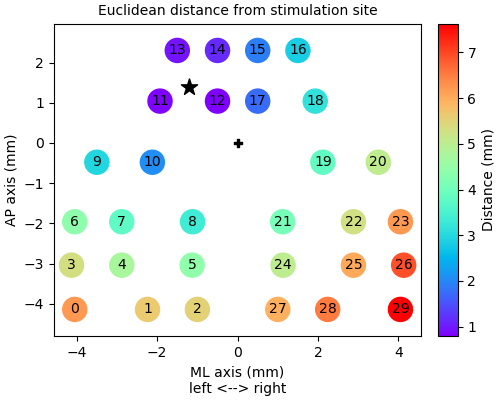

Text(0.5, 1.0, 'Euclidean distance from stimulation site')

In [21]:
fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)

dist_scatter = ax.scatter(EEGexp.EEG_channel_coordinates['ML'], EEGexp.EEG_channel_coordinates['AP'], c=ch_distances, s=300, cmap='rainbow')
ax.scatter(0, 0, marker='P', color='k')
ax.scatter(stim_elec_ML, stim_elec_AP, marker='*', color='k', s=150)
ax.axis('equal')
    
for ind in range(len(EEGexp.EEG_channel_coordinates)):
    ax.annotate(str(ind),  xy=(EEGexp.EEG_channel_coordinates['ML'].iloc[ind], EEGexp.EEG_channel_coordinates['AP'].iloc[ind]), ha='center', va='center', color="k")

cb = fig.colorbar(dist_scatter, ax=ax)
cb.set_label('Distance (mm)')
    
ax.set_xlabel('ML axis (mm)\nleft <--> right')
ax.set_ylabel('AP axis (mm)')
ax.set_title('Euclidean distance from stimulation site')

<IPython.core.display.Javascript object>


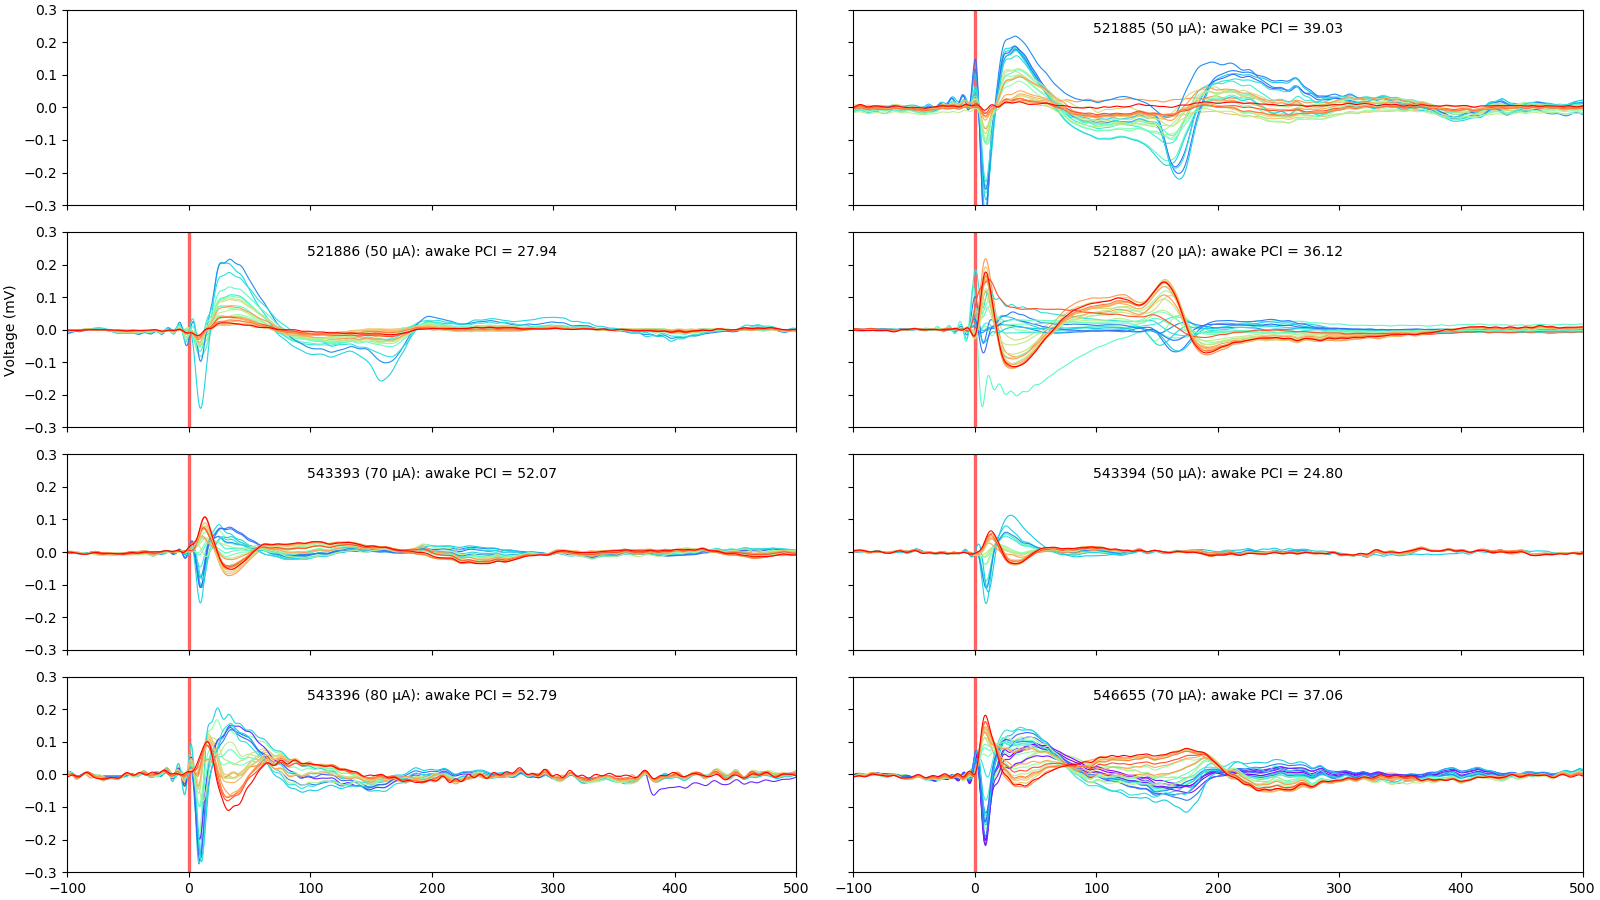

In [46]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots')
statei = 'awake' # 'awake' or 'anesthetized'

prex = 100 # ms before stim to plot
postx = 500 # ms after stim to plot
bf_ylimit = 0.3 # mV

fig, axs = plt.subplots(4, 2, figsize=(16, 9), sharex=True, sharey=True, constrained_layout=True)
for ax, subject in zip(axs.flatten()[1:], bf_avg_traces.keys()):
    good_chs = [x for x in eegchs if x not in bad_chs[subject]]
    
    pick_traces = bf_avg_traces[subject][statei][1]/1000 # or sub_avg_traces_filter
    pick_times = bf_avg_traces[subject][statei][0]
    plot_inds = np.squeeze(np.argwhere((pick_times >= -prex) & (pick_times <= postx)))
    for chi in good_chs:
        ax.plot(pick_times[plot_inds], pick_traces[plot_inds, chi], color=dist_scatter.to_rgba(ch_distances[chi]), linewidth=0.8)
        
    ax.axvspan(-1, 1, color='r', alpha=0.5)
    ax.set_ylim([-bf_ylimit, bf_ylimit])

    ax.set_xlim([-prex, postx])
#     ax.set_xlabel('Time from stim onset (ms)')

#     ax.set_title(('%s PCI = %0.2f' % (statei, full_PCI_output[subject][statei]['PCI'])), fontsize=10)
    ax.text(
        0.5, 0.9,
        ('%s (%d \u03BCA): %s PCI = %0.2f' % (subject[:6], PCI_stim_amp[subject], statei, full_PCI_output[subject][statei]['PCI'])),
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
    )

axs[1,0].set_ylabel('Voltage (mV)')
## Save butterfly figure ##
# fig.savefig(os.path.join(plotsavedir, 'mice7_BF_100Hzfilter_dist_AWAKE.png'), transparent=True)

### Plot array with good and bad electrodes

### Plot average traces as heatmaps, all brain states

<IPython.core.display.Javascript object>


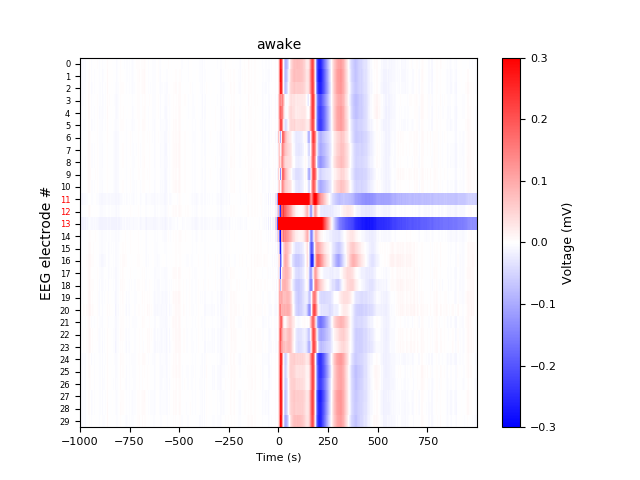

<IPython.core.display.Javascript object>


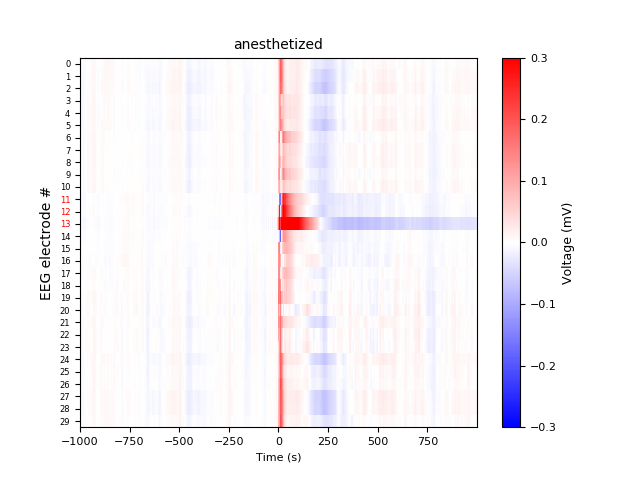

<IPython.core.display.Javascript object>


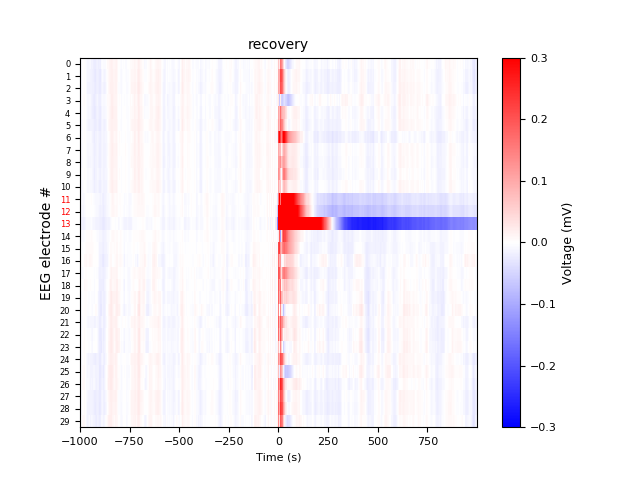

In [42]:
## Plot all chs, all states
pick_mouse = '543395b'
pick_traces = sub_avg_traces_filter # or sub_avg_traces_filter

mask_bad_chs = False
set_vrange = 0.3 # microvolts
turn_on_xlabels = True

for statei, amp_dict in pick_traces[pick_mouse].items():
    plot_time = pick_traces[pick_mouse][statei][str(PCI_stim_amp[pick_mouse])][0]
    plot_traces = pick_traces[pick_mouse][statei][str(PCI_stim_amp[pick_mouse])][1].T/1000
    
    if mask_bad_chs:
        mask_traces = np.zeros((len(bad_chs[pick_mouse]), np.shape(plot_traces)[1]))
        plot_traces[bad_chs[pick_mouse],:] = mask_traces

    fig, ax = plt.subplots() # figsize=(6,2.3)
    traces_plot = ax.imshow(plot_traces,
                            cmap='bwr',
                            aspect='auto',
                            vmin=-set_vrange,
                            vmax=set_vrange,
                            extent=[plot_time[0], plot_time[-1], len(eegchs), 0],
                           )
    ## Y labels
    ax.set_yticks(np.arange(len(eegchs))+0.5)
    ax.set_yticklabels(eegchs, fontsize=6)
    for ytick in ax.get_yticklabels():
        if int(ytick.get_text()) in bad_chs[pick_mouse]:
            ytick.set_color('r')
    ax.set_ylabel('EEG electrode #\nright <---> left hemisphere')
    ax.set_ylabel('EEG electrode #')
#     ax.axhline(len(eegchs)/2, color='k', linewidth=0.8)
#     ax.set_yticks([len(eegchs)/2])
#     ax.set_yticklabels([])
#     ax.set_ylabel('EEG\nright <---> left')

    ## X labels
    if turn_on_xlabels:
        ax.tick_params(axis='x', labelsize=8)
        ax.set_xlabel('Time (s)', fontsize=8)
    else:
        plt.tick_params(axis='x', labelbottom=False)

    ## Color bar
    cbar = plt.colorbar(traces_plot)
    cbar.set_label('Voltage (mV)', fontsize=9)
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(statei)

### Plot average traces as butterfly plot, all brain states

<IPython.core.display.Javascript object>


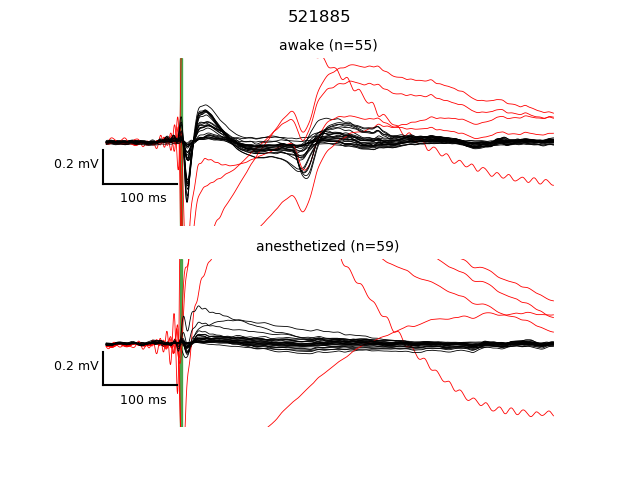

<IPython.core.display.Javascript object>


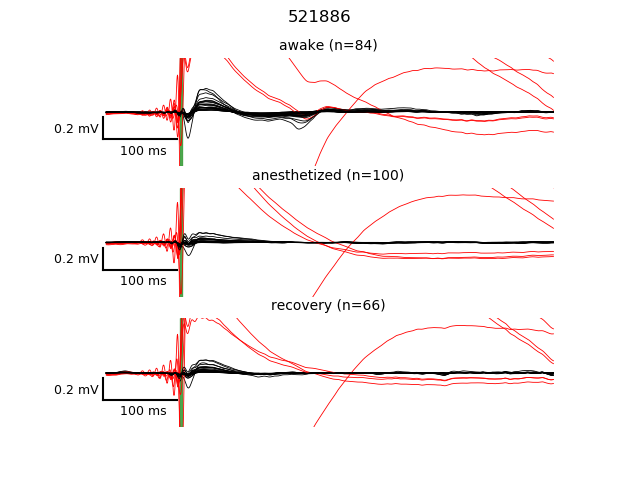

<IPython.core.display.Javascript object>


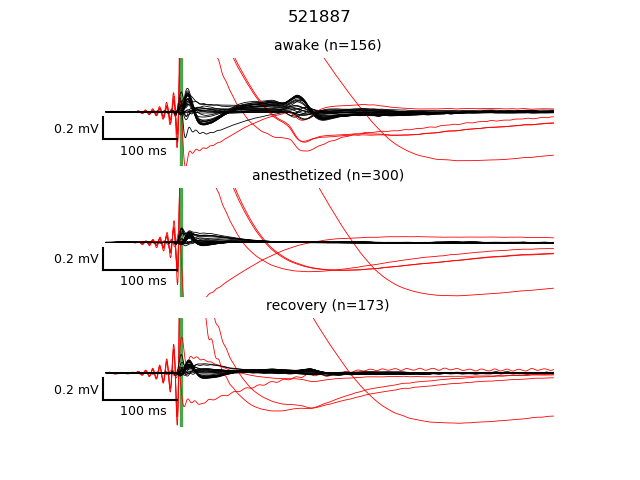

<IPython.core.display.Javascript object>


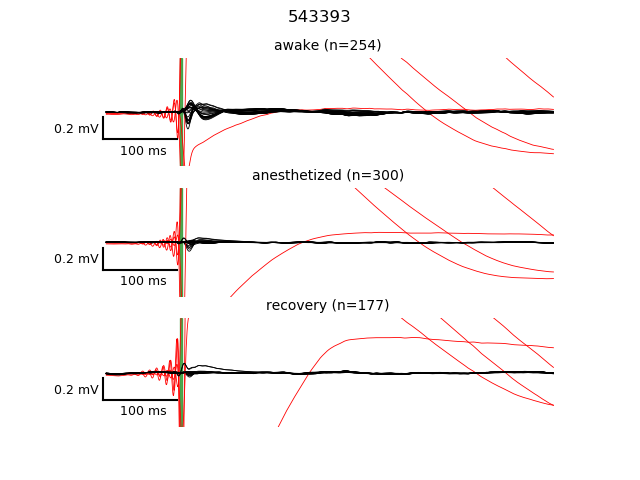

<IPython.core.display.Javascript object>


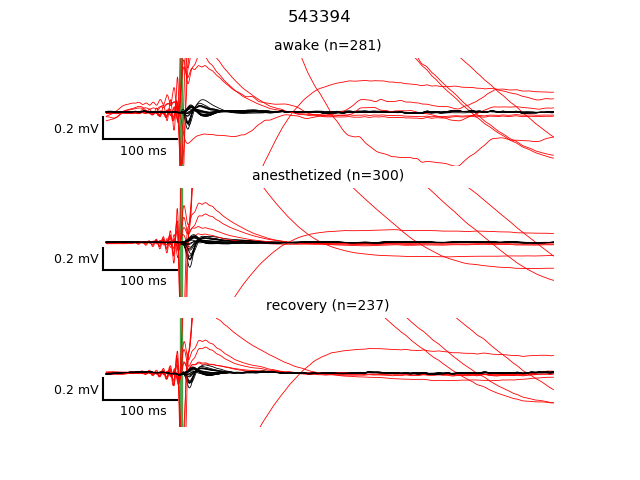

<IPython.core.display.Javascript object>


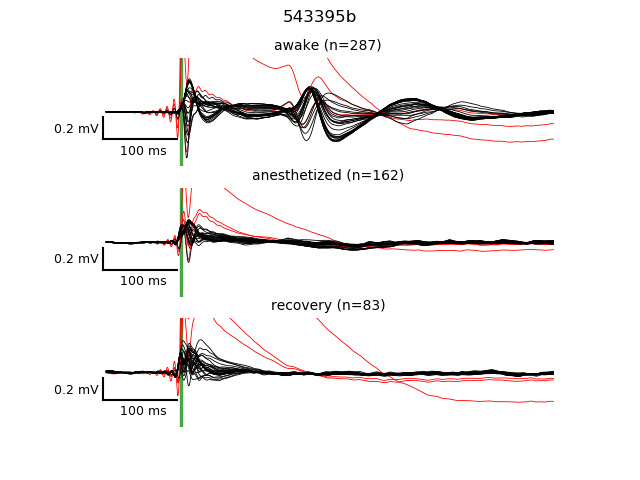

<IPython.core.display.Javascript object>


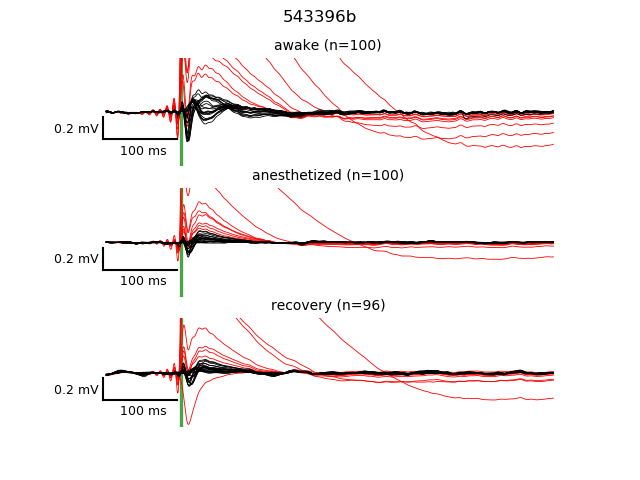

In [36]:
## Plot all chs, all states
pick_traces = sub_avg_traces_filter # or sub_avg_traces_filter
# bfplot_name = 'avg_traces_filter_butterfly.png'

prex = 100 # ms before stim to plot
postx = 500 # ms after stim to plot
ylimit = 0.5 # mV
time_scale = 100 # in ms?
mv_scale = 0.2 # in mV?
dx = 5
dy = 0.05

mask_bad_chs = True
set_vrange = 0.3 # microvolts
turn_on_xlabels = True

for subject, all_states in pick_traces.items():
    
    ## Check directory for saving plots ##
    plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse'+subject[:6])
    if not os.path.exists(plotsavedir):
        os.mkdir(plotsavedir)
    
    PCIamp = str(PCI_stim_amp[subject])
    fig, axs = plt.subplots(len(all_states))
    fig.suptitle(subject)
    for ax, statei in zip(axs, pick_traces[subject].keys()):
        plot_time = pick_traces[subject][statei][PCIamp][0]
        plot_traces = pick_traces[subject][statei][PCIamp][1]/1000
        plot_inds = np.squeeze(np.argwhere((plot_time >= -prex) & (plot_time <= postx)))
        if mask_bad_chs:
            for chi in eegchs:
                if chi in bad_chs[subject]:
                    ax.plot(plot_time[plot_inds], plot_traces[plot_inds,chi], color='r', linewidth=0.6)
                else:
                    ax.plot(plot_time[plot_inds], plot_traces[plot_inds,chi], color='k', linewidth=0.6)
        else:
            ax.plot(plot_time[plot_inds], plot_traces[plot_inds,:], color='k', linewidth=0.6)
        ax.axvspan(-1, 1, color='g', alpha=0.6)
#         ax.set_xlim([-prex, postx])
        ax.set_ylim([-ylimit, ylimit])
        ax.axis('off')
#         ax.set_ylabel(statei)
        
        ## add scale bar ##
        ax.plot([-time_scale-dx, 0-dx], [-mv_scale-dy, -mv_scale-dy], 'k') # horizontal scale bar
        ax.plot([-time_scale-dx, -time_scale-dx], [-mv_scale-dy, 0-dy], 'k') # vertical scale bar
        ax.annotate(('%s ms' % time_scale), xy=(-time_scale/2,-mv_scale-dy*2), ha='center', va='top', fontsize=9)
        ax.annotate(('%s mV' % mv_scale), xy=(-time_scale-dx*2,-mv_scale/2), ha='right', va='top', fontsize=9)
        
        ## number of trials per state ##
        ax.set_title(('%s (n=%s)' % (statei, sub_num_trials[subject][statei][PCIamp])), fontsize=10)
        
    ## Save figure? ##
#     fig.savefig(os.path.join(plotsavedir, bfplot_name), transparent=True)

### Plotting other PCI info

<IPython.core.display.Javascript object>


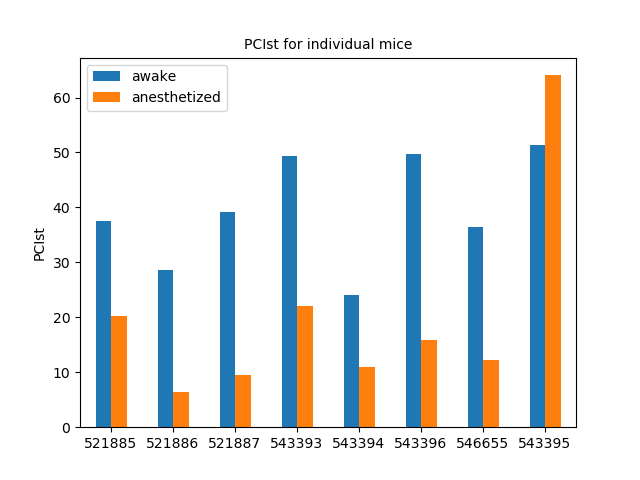

Text(0, 0.5, 'PCIst')

In [34]:
pciax = pci_eqn.T.plot.bar(rot=0)
pciax.set_title('PCIst for individual mice')
pciax.set_ylabel('PCIst')

In [37]:
num_goodchs = [(30 - len(bad_chs[x])) for x in sub_list]
numchsdf = pd.DataFrame({'subjects':sub_list, 'good_chs':num_goodchs})
numchsdf.head()

,subjects,good_chs
0,521885,25
1,521886,23
2,521887,25
3,543393,26
4,543394,21


<IPython.core.display.Javascript object>


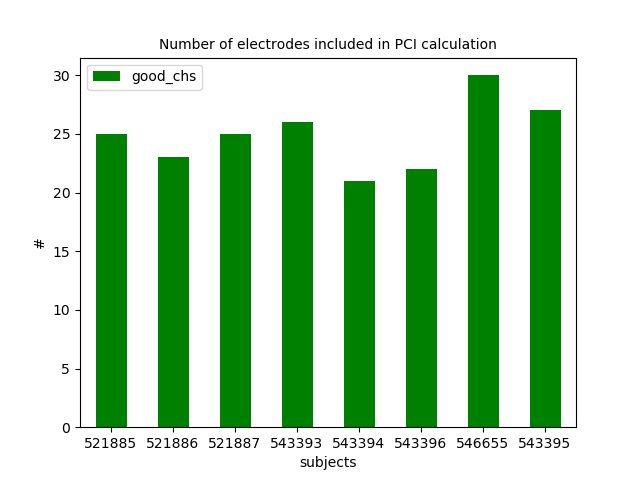

Text(0, 0.5, '#')

In [43]:
numchsax = numchsdf.plot.bar(x='subjects', y='good_chs', rot=0, color='g')
numchsax.set_title('Number of electrodes included in PCI calculation')
numchsax.set_ylabel('#')

In [49]:
## Number of PCs ##
numPCs = {}
for mousei in full_PCI_output.keys():
    numPCs[mousei] = {}
    for statei in full_PCI_output[mousei].keys():
        numPCs[mousei][statei] = full_PCI_output[mousei][statei]['n_dims']
pcdf = pd.DataFrame(numPCs)
pcdf.head()

,521885,521886,521887,543393,543394,543396,546655,543395
awake,4,3,4,5,4,5,4,4
anesthetized,4,2,3,5,3,4,4,6


<IPython.core.display.Javascript object>


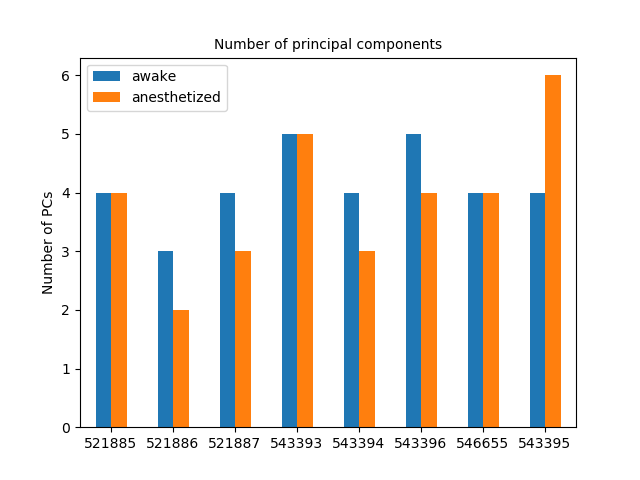

Text(0, 0.5, 'Number of PCs')

In [53]:
pcax = pcdf.T.plot.bar(rot=0)
pcax.set_title('Number of principal components')
pcax.set_ylabel('Number of PCs')

In [63]:
## State transitions ##
state_trans = {}
for mousei in full_PCI_output.keys():
    state_trans[mousei] = {}
    for statei in full_PCI_output[mousei].keys():
        state_trans[mousei][statei] = full_PCI_output[mousei][statei]['dNST']
state_trans = pd.DataFrame(state_trans)
state_trans.head()

,521885,521886,521887,543393,543394,543396,546655,543395
awake,"[9.15205704736733, 6.203734778310154, 10.42098...","[8.43370318609337, 10.292494441047074, 9.89278...","[8.813151563753006, 2.947072975140337, 11.3147...","[9.14514835605453, 9.017690321663512, 11.37859...","[8.115994268888329, 5.602204601324243, 6.49224...","[6.8609272584577745, 8.142622277440216, 8.9245...","[8.385939888004387, 6.807509636787066, 8.28900...","[10.211723514887408, 13.329314889141237, 12.06..."
anesthetized,"[4.865276663993584, 6.174193249943849, 3.79359...","[4.107691506953968, 2.279496711115553]","[2.2670408981555736, 4.467438616733415, 2.7254...","[5.296607219753444, 2.3155357238536194, 1.4030...","[4.463512429831596, 2.135707227177573, 4.39405...","[5.1436859434042095, 2.217321571772253, 1.9374...","[3.0529270248596636, 4.099503718317453, 3.1059...","[3.6135162673206627, 9.386990514784793, 11.639..."


<IPython.core.display.Javascript object>


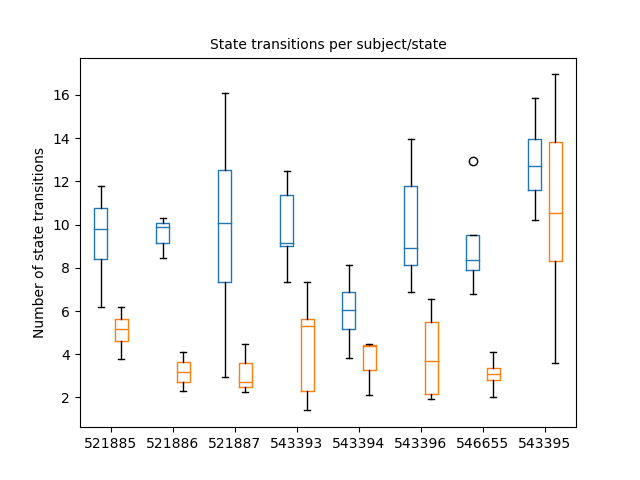

Text(0.5, 1.0, 'State transitions per subject/state')

In [76]:
fig, ax = plt.subplots()

start = 1
for ii, subject in enumerate(sub_list):
    for jj, statei in enumerate(state_trans[subject].keys()):
        if statei == 'awake':
            boxc = '#1f77b4'
        else:
            boxc = '#ff7f0e'
        ax.boxplot(
            state_trans[subject][statei],
            positions=[start],
            widths=0.6,
            boxprops=dict(color=boxc),
            medianprops=dict(color=boxc)
        )
        start += 1
    start += 1

ax.set_xlim(0,start-1)
ax.set_xticklabels(sub_list)
ax.set_xticks([1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 22.5])
ax.set_ylabel('Number of state transitions')
ax.set_title('State transitions per subject/state')

## OLD STUFF

### Calculate PCIst

In [26]:
pick_traces = sub_avg_traces_filter # or sub_avg_traces_filter

PCI_params = {
    'baseline_window':(-500, -1), # ms before stim for baseline
    'response_window':(1, 500), # ms after stim for response
    'k':1.2,
    'min_snr':1.1,
    'max_var':99,
    'embed':False,
    'n_steps':100,
}

all_sub_PCIst = {}
sub_list = []

for subject in pick_traces.keys():
    print(subject)
    start = time.time()
    PCIamp = str(PCI_stim_amp[subject])
    good_chs = [x for x in eegchs if x not in bad_chs[subject]]
    sub_list.append(subject[:6])
    all_sub_PCIst[subject] = {}
    for statei in pick_traces[subject].keys():
        
        ## Calculate PCIst ##
        all_sub_PCIst[subject][statei] = calc_PCIst(
            pick_traces[subject][statei][PCIamp][1][:, good_chs].T,
            pick_traces[subject][statei][PCIamp][0],
            **PCI_params
        )
    end = time.time()
    print('PCI time: %0.2f s' % (end-start))

521885
PCI time: 76.73 s
521886
PCI time: 76.35 s
521887


KeyboardInterrupt: 

### Plot PCIst for all subjects

<IPython.core.display.Javascript object>


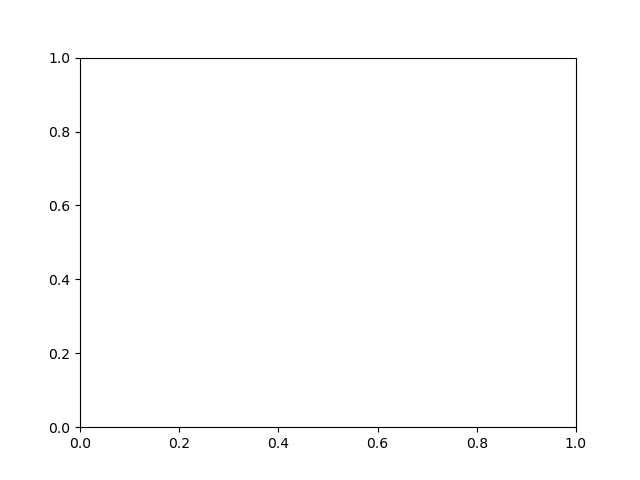

NameError: name 'PCIvalues' is not defined

In [27]:
fig, ax = plt.subplots()
ax.plot(
    np.arange(0, PCIvalues.shape[0]),
    PCIvalues,
    marker='o',
)
ax.set_xticks(np.arange(0, PCIvalues.shape[0]))
ax.set_xticklabels(list(dfpci.index.values))
ax.set_ylabel('PCIst')
ax.legend(sub_list)

In [28]:
pci_eqn = pd.DataFrame(all_sub_PCIst_eqn)
# pci_eqn.head()
PCIvalues_eqn = pci_eqn.to_numpy()

fig, ax = plt.subplots()
ax.plot(
    np.arange(0, PCIvalues_eqn.shape[0]),
    PCIvalues_eqn,
    marker='o',
)
ax.set_xticks(np.arange(0, PCIvalues_eqn.shape[0]))
ax.set_xticklabels(list(pci_eqn.index.values))
ax.set_ylabel('PCIst')
ax.legend(sub_list)
ax.set_title(
    'Filtered traces, trial num matched within subject\nBaseline (%d, %d), Response (%d, %d)\nmin_snr=%0.2f' % (
        PCI_params['baseline_window'][0],
        PCI_params['baseline_window'][1],
        PCI_params['response_window'][0],
        PCI_params['response_window'][1],
        PCI_params['min_snr'],
    ))

NameError: name 'all_sub_PCIst_eqn' is not defined

#### Plot figure

<IPython.core.display.Javascript object>


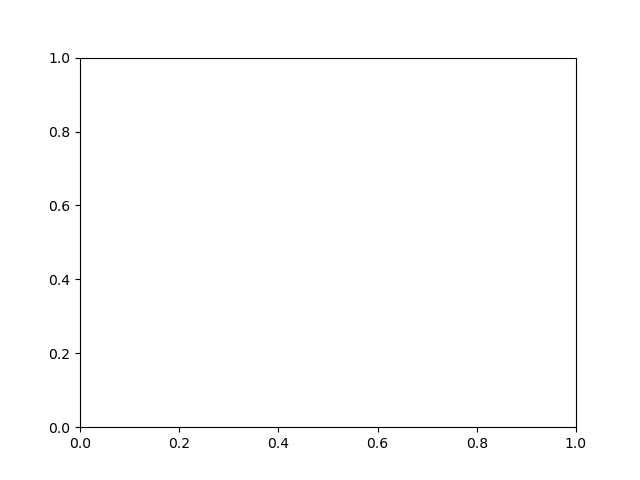

NameError: name 'awake_anestPCI' is not defined

In [29]:
fig, ax = plt.subplots()
# plot individuals with unfilled circles
individs = ax.plot(
    np.arange(0, awake_anestPCI.shape[0]),
    awake_anestPCI,
    color='k',
    linewidth=1,
    marker='o',
    fillstyle='none'
)
# plot mean +/- SEM with filled circles
mean_sem = ax.errorbar(
    np.arange(0, awake_anestPCI.shape[0]),
    np.mean(awake_anestPCI, axis=1),
    yerr=stats.sem(awake_anestPCI, axis=1),
    color='dodgerblue',
    linewidth=2,
    marker='o',
    markersize=8,
)

ax.set_xlim([-0.25, 1.25])
ax.set_xticks(np.arange(0, awake_anestPCI.shape[0]))
ax.set_xticklabels(['awake', 'anesthetized'])
ax.set_ylabel('PCI')
ax.legend([individs[0], mean_sem], [('Individual (n=%d)' % awake_anestPCI.shape[1]), 'Mean +/- SEM'])
ax.set_title(
    'Filtered traces, trial num matched within subject\nBaseline (%d, %d), Response (%d, %d)\nmin_snr=%0.2f, p=%0.03f' % (
        PCI_params['baseline_window'][0],
        PCI_params['baseline_window'][1],
        PCI_params['response_window'][0],
        PCI_params['response_window'][1],
        PCI_params['min_snr'],
        p2
    ))

## Save
# fig.savefig(os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'PCIst_forppt.png'), transparent=True)

### Plot butterflies with PCs

In [16]:
pick_mouse = '543395b'
pick_traces = sub_traces_filter # choose either the traces of the traces_filter
states = ['awake', 'anesthetized']

PCI_params = {
    'baseline_window':(-500, -1), # ms before stim for baseline
    'response_window':(1, 500), # ms after stim for response
    'k':1.2,
    'min_snr':1.1,
    'max_var':99,
    'embed':False,
    'n_steps':100,
}

good_chs = [x for x in eegchs if x not in bad_chs[pick_mouse]]
PCIamp = str(PCI_stim_amp[pick_mouse])
NUM_TRIALS = min([sub_num_trials[pick_mouse][x][PCIamp] for x in states])

full_PCI_output = {}
bf_avg_traces = {}
for statei in states:
    print(statei)
    start = time.time()
    ## Subselect trials and take avg ##
    if statei == 'recovery':
        avg_traces = np.mean(pick_traces[pick_mouse][statei][PCIamp][1][:, :, -NUM_TRIALS:], axis=2)
    else:
        avg_traces = np.mean(pick_traces[pick_mouse][statei][PCIamp][1][:, :, :NUM_TRIALS], axis=2)
    bf_avg_traces[statei] = [pick_traces[pick_mouse][statei][PCIamp][0], avg_traces]

#     ## Use dimensionality_reduction to get PCs ##
#     signal_svd, var_exp, eigenvalues, snrs = dimensionality_reduction(
#         avg_traces[:, good_chs].T,
#         pick_traces[pick_mouse][statei][PCIamp][0],
#         **PCI_params
#     )
    
    ## Calculate PCIst with full return ##
    full_PCI_output[statei] = calc_PCIst(
        avg_traces[:, good_chs].T,
        pick_traces[pick_mouse][statei][PCIamp][0],
        full_return=True,
        **PCI_params
    )
    
    print('PCI = %0.3f' % full_PCI_output[statei]['PCI'])
    end = time.time()
    print('Time: %0.2f s' % (end-start))

awake
PCI = 49.718
Time: 46.57 s
anesthetized
PCI = 61.887
Time: 74.86 s


<IPython.core.display.Javascript object>


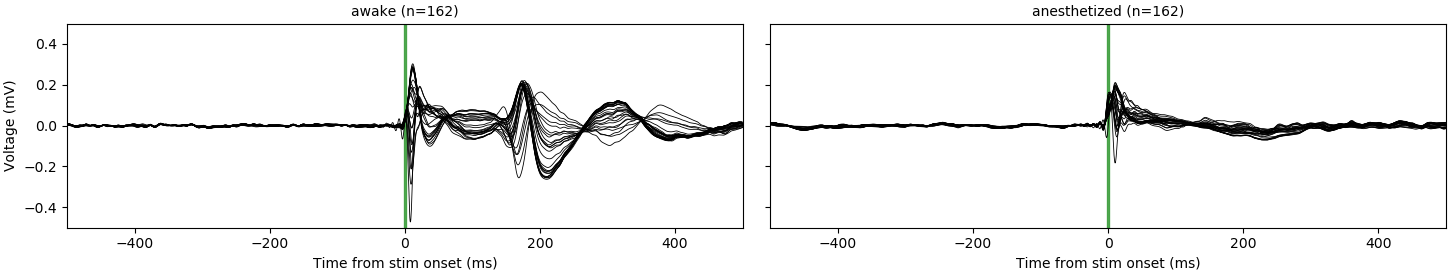

<IPython.core.display.Javascript object>


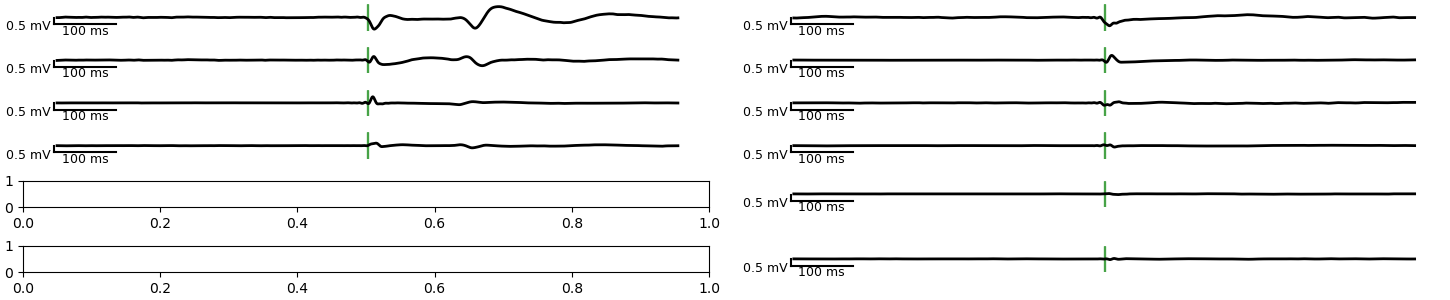

In [23]:
bfplot_name = 'avg_traces_filter_butterfly1_onlygood.png'
pcplot_name = 'PCs_plot1.png'

prex = 500 # ms before stim to plot
postx = 500 # ms after stim to plot
bf_ylimit = 0.5 # mV
pc_ylimit = 1.1 # mV
time_scale = 100 # in ms?
mv_scale = 0.5 # in mV?
dx = 5
dy = 0.05

mask_bad_chs = False
scale_bar_butterfly = False
scale_bar_PCs = True
NUM_PCs = max([full_PCI_output[x]['signal_svd'].shape[0] for x in states])

## Check directory for saving plots ##
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse'+pick_mouse[:6])
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

## Butterfly figure with avg traces ##
fig, axs = plt.subplots(1, len(states), figsize=(14.5, 2.75), constrained_layout=True)
for ax, statei in zip(axs, states):
    pick_traces = bf_avg_traces[statei][1]/1000 # or sub_avg_traces_filter
    pick_times = bf_avg_traces[statei][0]
    plot_inds = np.squeeze(np.argwhere((pick_times >= -prex) & (pick_times <= postx)))
    if mask_bad_chs:
        for chi in eegchs:
            if chi in bad_chs[pick_mouse]:
                ax.plot(pick_times[plot_inds], pick_traces[plot_inds, chi], color='r', linewidth=0.6)
            else:
                ax.plot(pick_times[plot_inds], pick_traces[plot_inds, chi], color='k', linewidth=0.6)
    else:
        ax.plot(pick_times[plot_inds], pick_traces[plot_inds,:][:,good_chs], color='k', linewidth=0.6)
    ax.axvspan(-1, 1, color='g', alpha=0.6)
    ax.set_ylim([-bf_ylimit, bf_ylimit])

    if scale_bar_butterfly:
        ax.axis('off')
        ## add scale bar ##
        ax.plot([-time_scale-dx, 0-dx], [-mv_scale-dy, -mv_scale-dy], 'k') # horizontal scale bar
        ax.plot([-time_scale-dx, -time_scale-dx], [-mv_scale-dy, 0-dy], 'k') # vertical scale bar
        ax.annotate(('%s ms' % time_scale), xy=(-time_scale/2,-mv_scale-dy*2), ha='center', va='top', fontsize=9)
        ax.annotate(('%s mV' % mv_scale), xy=(-time_scale-dx*2,-mv_scale/2), ha='right', va='top', fontsize=9)
    else:
        ax.set_xlim([-prex, postx])
        ax.set_xlabel('Time from stim onset (ms)')
        ax.set_ylabel('Voltage (mV)')

    ## number of trials per state ##
    ax.set_title(('%s (n=%s)' % (statei, NUM_TRIALS)), fontsize=10)
ax.set_ylabel('')
ax.set_yticklabels([])

## Save butterfly figure ##
# fig.savefig(os.path.join(plotsavedir, bfplot_name), transparent=True)

## Plot PCs for each state ##
fig, axs = plt.subplots(NUM_PCs, len(states), figsize=(14.5, 3), constrained_layout=True)
for ii, statei in enumerate(states):
    pick_traces = full_PCI_output[statei]['signal_svd']/1000 # or sub_avg_traces_filter
    pick_times = full_PCI_output[statei]['times']
    for jj in range(pick_traces.shape[0]):
#     plot_inds = np.squeeze(np.argwhere((pick_times >= -prex) & (pick_times <= postx)))
        axs[jj,ii].plot(pick_times, pick_traces[jj, :], color='k', linewidth=2)
        axs[jj,ii].axvspan(-1, 1, color='g', alpha=0.6)
        axs[jj,ii].set_ylim([-pc_ylimit, pc_ylimit])

        if scale_bar_PCs:
            axs[jj,ii].axis('off')
            ## add scale bar ##
            axs[jj,ii].plot([pick_times[0]-dx, pick_times[0]-dx+time_scale], [-mv_scale-dy, -mv_scale-dy], 'k') # horizontal scale bar
            axs[jj,ii].plot([pick_times[0]-dx, pick_times[0]-dx], [-mv_scale-dy, 0-dy], 'k') # vertical scale bar
            axs[jj,ii].annotate(('%s ms' % time_scale), xy=(pick_times[0]-dx+time_scale/2,-mv_scale-dy*2), ha='center', va='top', fontsize=9)
            axs[jj,ii].annotate(('%s mV' % mv_scale), xy=(pick_times[0]-dx*2,-mv_scale/2), ha='right', va='top', fontsize=9)
        else:
            axs[jj,ii].set_xlim([pick_times[0], pick_times[-1]])
            axs[jj,ii].set_xlabel('Time from stim onset (ms)')
            axs[jj,ii].set_ylabel('Voltage (mV)')

        ## number of trials per state ##
#         ax.set_title(('%s (n=%s)' % (statei, NUM_TRIALS)), fontsize=10)
#     axs[jj,ii].set_ylabel('')
#     axs[jj,ii].set_yticklabels([])
# for ax in axs.flat:
#     ax.label_outer()

## Save butterfly figure ##
# fig.savefig(os.path.join(plotsavedir, pcplot_name), transparent=True)

#### Plot distance matrices for one PC

In [ ]:
pickPC = 0
ind = np.squeeze(np.argmax(full_PCI_output['awake']['NST_diff'][:,pickPC]))
print('Baseline num state trans = %0.5f' % full_PCI_output['awake']['NST_base'][ind,pickPC])
print('Response num state trans = %0.5f' % full_PCI_output['awake']['NST_resp'][ind,pickPC])
print('dNST = %0.5f' % full_PCI_output['awake']['dNST'][pickPC])
print('awake PCI = %0.5f' % full_PCI_output['awake']['PCI'])
print('anesthetized PCI = %0.5f' % full_PCI_output['anesthetized']['PCI'])

In [ ]:
cbar_range = 1

fig, axs = plt.subplots(2)

BL = axs[0].imshow(
    full_PCI_output['awake']['D_base'][pickPC,:,:]/1000,
    cmap='Greys',
    aspect='equal',
    vmin=0,
    vmax=cbar_range,
    extent=[PCI_params['baseline_window'][0],PCI_params['baseline_window'][1],PCI_params['baseline_window'][1],PCI_params['baseline_window'][0]]
)
axs[0].set_ylabel('Baseline')
axs[0].set_xticks([PCI_params['baseline_window'][0],PCI_params['baseline_window'][1]])
axs[0].set_xticklabels([PCI_params['baseline_window'][0],PCI_params['baseline_window'][1]])
# axs[0].set_xlabel('Time (ms)')
axs[0].set_yticks([PCI_params['baseline_window'][1],PCI_params['baseline_window'][0]])
axs[0].set_yticklabels([PCI_params['baseline_window'][1],PCI_params['baseline_window'][0]])
# axs[0].set_ylabel('Time (ms)')

# cbar = plt.colorbar(BL, ax=axs[0])
# cbar.set_label('Distance', fontsize=9)
# cbar.ax.tick_params(labelsize=8)

RP = axs[1].imshow(
    full_PCI_output['awake']['D_resp'][pickPC,:,:]/1000,
    cmap='Greens',
    aspect='equal',
    vmin=0,
    vmax=cbar_range,
    extent=[PCI_params['response_window'][0],PCI_params['response_window'][1],PCI_params['response_window'][1],PCI_params['response_window'][0]]
)
axs[1].set_ylabel('Response')
axs[1].set_xticks([PCI_params['response_window'][0],PCI_params['response_window'][1]])
axs[1].set_xticklabels([PCI_params['response_window'][0],PCI_params['response_window'][1]])
axs[1].set_xlabel('Time (ms)')
axs[1].set_yticks([PCI_params['response_window'][1],PCI_params['response_window'][0]])
axs[1].set_yticklabels([PCI_params['response_window'][1],PCI_params['response_window'][0]])
# axs[1].set_ylabel('Time (ms)')

# cbar = plt.colorbar(RP, ax=axs[1], shrink=0.45)
# cbar.set_label('mV', fontsize=9)
# cbar.ax.tick_params(labelsize=8)

# fig.savefig(os.path.join(plotsavedir, 'dist_matrices_awake_PC0.png'), transparent=True)

#### Plot the transition matrices for one PC

In [ ]:
cbar_range = 0.25

fig, axs = plt.subplots(2)

BL = axs[0].imshow(
    full_PCI_output['awake']['T_base'][pickPC,:,:],
    cmap='binary',
    aspect='equal',
    interpolation='bilinear',
    vmin=0,
    vmax=cbar_range,
    extent=[PCI_params['baseline_window'][0],PCI_params['baseline_window'][1],PCI_params['baseline_window'][1],PCI_params['baseline_window'][0]]
)
axs[0].set_ylabel('Baseline')
axs[0].set_xticks([PCI_params['baseline_window'][0],PCI_params['baseline_window'][1]])
axs[0].set_xticklabels([PCI_params['baseline_window'][0],PCI_params['baseline_window'][1]])
# axs[0].set_xlabel('Time (ms)')
axs[0].set_yticks([PCI_params['baseline_window'][1],PCI_params['baseline_window'][0]])
axs[0].set_yticklabels([PCI_params['baseline_window'][1],PCI_params['baseline_window'][0]])
# axs[0].set_ylabel('Time (ms)')

# cbar = plt.colorbar(BL, ax=axs[0])
# cbar.set_label('Distance', fontsize=9)
# cbar.ax.tick_params(labelsize=8)

RP = axs[1].imshow(
    full_PCI_output['awake']['T_resp'][pickPC,:,:],
    cmap='binary',
    aspect='equal',
    interpolation='bilinear',
    vmin=0,
    vmax=cbar_range,
    extent=[PCI_params['response_window'][0],PCI_params['response_window'][1],PCI_params['response_window'][1],PCI_params['response_window'][0]]
)
axs[1].set_ylabel('Response')
axs[1].set_xticks([PCI_params['response_window'][0],PCI_params['response_window'][1]])
axs[1].set_xticklabels([PCI_params['response_window'][0],PCI_params['response_window'][1]])
axs[1].set_xlabel('Time (ms)')
axs[1].set_yticks([PCI_params['response_window'][1],PCI_params['response_window'][0]])
axs[1].set_yticklabels([PCI_params['response_window'][1],PCI_params['response_window'][0]])
# axs[1].set_ylabel('Time (ms)')

# cbar = plt.colorbar(RP, ax=axs[1], shrink=0.45)
# cbar.set_label('mV', fontsize=9)
# cbar.ax.tick_params(labelsize=8)

# fig.savefig(os.path.join(plotsavedir, 'trans_matrices_awake_PC0.png'), transparent=True)